# Set up environment

In [1]:
!nvidia-smi

import os
HOME = os.getcwd()

Fri Dec  1 05:17:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# # change "/content/gdrive/MyDrive/"  to "/mydrive so you can use directly /mydrive"
# !ln -s /content/gdrive/MyDrive/ /mydrive

In [24]:
!gdown https://drive.google.com/uc?id=1ibVpNvQci2T-phUeV8aT8kfFd8eRkyqL
!gdown https://drive.google.com/uc?id=1jofip_UbAXzzJwrqacVTJ7183mmpBQXe
!gdown https://drive.google.com/uc?id=1q3myiaORcL3fbeks8ExZZcqefFtHthPD

Downloading...
From: https://drive.google.com/uc?id=1ibVpNvQci2T-phUeV8aT8kfFd8eRkyqL
To: /content/vi-model-CBOW.bin
100% 699M/699M [00:09<00:00, 77.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jofip_UbAXzzJwrqacVTJ7183mmpBQXe
To: /content/vlsp_sentiment_test.csv
100% 159k/159k [00:00<00:00, 132MB/s]
Downloading...
From: https://drive.google.com/uc?id=1q3myiaORcL3fbeks8ExZZcqefFtHthPD
To: /content/vlsp_sentiment_train.csv
100% 858k/858k [00:00<00:00, 170MB/s]


In [4]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 16.0 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from string import digits
from pyvi import ViTokenizer
from gensim.models.keyedvectors import KeyedVectors

from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.models import Model

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

%matplotlib inline

In [98]:
# Seperating validation and training accuracy
def train_plot(history, name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Seperating validation and training loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plotting
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title(f'{name}: Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['TrainingAccuracy', 'Validation Accuracy'])

    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title(f'{name}: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training Loss', 'Validation Loss'])

    plt.show()

In [56]:
def confusion_matrix_plot(predictions, labels):
    true_labels = np.argmax(labels, axis=1)
    pred_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(true_labels, pred_labels)

    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'], cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Labeled')

def result_test(predictions, labels):
    true_labels = np.argmax(labels, axis=1)
    pred_labels = np.argmax(predictions, axis=1)
    return {
        'Accuracy': accuracy_score(true_labels, pred_labels),
        'Recall': recall_score(true_labels, pred_labels, average='macro'),
        'Precision': precision_score(true_labels, pred_labels, average='macro'),
        'F1-Score': f1_score(true_labels, pred_labels, average='macro')
    }

# Data preprocessing

## Discover data

In [103]:
data_train = pd.read_csv("vlsp_sentiment_train.csv", sep='\t')
data_test = pd.read_csv("vlsp_sentiment_test.csv", sep='\t')
data_train

,Class,Data
0,-1,"Mình đã dùng anywhere thế hệ đầu, quả là đầy t..."
1,-1,"Quan tâm nhất là độ trễ có cao không, dùng thi..."
2,-1,"dag xài con cùi bắp 98k....pin trâu, mỗi tội đ..."
3,-1,logitech chắc hàng phải tiền triệu trở lên dùn...
4,-1,"Đang xài con m175 cùi mía , nhà xài nhiều chuộ..."
...,...,...
5095,0,Mình mua máy về đc 1 ngày mà điện thoại khác g...
5096,0,Có bạn nào dùng f1w ko.mình dùng m cảm thấy qu...
5097,0,Dùng oppo mà bộ nhớ 4gb thì k chơi games ...
5098,0,Sao tui thích xài hàng oppo mà lựa toàn mấy đứ...


from matplotlib import pyplot as plt
data_train['Class'].plot(kind='hist', bins=20, title='Class')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data_train['Class'].plot(kind='line', figsize=(8, 4), title='Class')
plt.gca().spines[['top', 'right']].set_visible(False)

Data size

In [9]:
print(data_train.shape)
print(data_test.shape)

(5100, 2)
(1050, 2)


Check null and check if class value is just in {-1, 0, 1}

In [10]:
print(data_train.isnull().sum())
print(set(data_train['Class']))

Class    0
Data     0
dtype: int64
{0, 1, -1}


## Process labels to one-hot vector

Encode labels to one-hot

*   [1, 0, 0] for negative
*   [0, 1, 0] for neutral
*   [0, 0, 1] for positive

In [11]:
labels = data_train.iloc[:, 0].values
labels_test = data_test.iloc[:, 0].values

In [12]:
encoded_labels = np.array(
    [
             [1, 0, 0] if label == -1
        else [0, 1, 0] if label == 0
        else [0, 0, 1]
             for label in labels
    ]
)

encoded_labels_test = np.array(
    [
             [1, 0, 0] if label == -1
        else [0, 1, 0] if label == 0
        else [0, 0, 1]
             for label in labels_test
    ]
)

In [13]:
labels = encoded_labels
labels_test = encoded_labels_test

## Remove words with digits

Word with digits is usually unique and hard to trained to actually contribute to the sentiment analysis.

In [14]:
# Function to print words with digits
def printWordWithDigits(review) :
    for word in review.split(' '):
        for char in word:
            if char.isdigit():
                print(word, end=' ')
                break
    return review

data_train['Data'] = data_train['Data'].apply(printWordWithDigits)
data_test['Data'] = data_test['Data'].apply(printWordWithDigits)

98k....pin 2 400k m175 3 4 m175 :3 2 M185, 1 3 1/3. 2 1 1tr7 1 10.11.3 10.11.3 13" 2015 2 10.11.3 M905 1tr8 2015 13 A9 1 30 60$ 1 200$. 300$ 5 2 90% 2 2 8-10tr 3 2000 2 300-400$ 1 300-400$ 1 300-400$ 1 1 1 1 1 2 1 100% 6 6 6 100 2 ip6+ 3 1 1 1 90% 1 1 1 6h 1 2 2 2 $40-$50 5-7 2 1 3-4 6, ip5, 1 10tr 1 2 1 24/24. 2,3 S2 x8 10m, (50m) 1/2 M600 2 2 1. https://drive.google.com/file/d/0B5HmAZf5BrURY0ZUN3l3VWMwV2c/view?usp=sharing 151015-105213.jpg 2. https://drive.google.com/file/d/0B5HmAZf5BrURZHlFdFJPcHhDa3M/view?usp=sharing Nokia1202 1S 2 1 2 2 2 i5+ 1 2 2 https://goo.gl/photos/DfXh6yKUgsXzQrWB6 1s E200 N3060 470 480 960.. 3tr 1060 3GB 480-460 10 S6 1 3.200 A7 Ip6. 2 s6. 6 2 ip6 3 4 5 S3 2012. 4 5 S3 1-2 1 s7 2 5 1 1 iphone6 s6 6 s6 ip6 3000ma 6 9.1 9.1 9.3.1 9.9.2 S6 S7 S6 S6 S6 S7 5s 6 6s 1 4 1 iphone2. 6 7 16GB 16G 16G 128G 256 64 2016 16 64GB 16GB 24h 1 2 1. BB10 2. 6GB 2GB 6GB 9.3.1 4s 10gb 3Gb 6Gb 2Gb 3000mAh. 6s S7 G5 Z5.... s7 s7 12tr 17 A5-06 S7 S6 IP7 6 6s iphone8 s7edge 5s, 6s 

We will remove those words to help our dictionary cleaner

In [15]:
# Function to detect word with digits
def contains_digits(word) :
    for char in word:
        if char.isdigit():
            return True
    return False

# Function to remove word with digits
remove_word_with_digits = lambda review: ' '.join(
    word for word in review.split(' ') if not contains_digits(word)
)

# Apply the function to the 'Data' column
data_train['Data'] = data_train['Data'].apply(remove_word_with_digits)
data_test['Data'] = data_test['Data'].apply(remove_word_with_digits)

In [16]:
data_train

,Class,Data
0,-1,"Mình đã dùng anywhere thế hệ đầu, quả là đầy t..."
1,-1,"Quan tâm nhất là độ trễ có cao không, dùng thi..."
2,-1,"dag xài con cùi bắp trâu, mỗi tội đánh liên mi..."
3,-1,logitech chắc hàng phải tiền triệu trở lên dùn...
4,-1,"Đang xài con cùi mía , nhà xài nhiều chuột nên..."
...,...,...
5095,0,Mình mua máy về đc ngày mà điện thoại khác gọi...
5096,0,Có bạn nào dùng ko.mình dùng m cảm thấy quanh ...
5097,0,Dùng oppo mà bộ nhớ thì k chơi games đc đ...
5098,0,Sao tui thích xài hàng oppo mà lựa toàn mấy đứ...


Save to processed reviews in ```reviews```

In [17]:
reviews = data_train.iloc[:, 1].values
reviews_test = data_test.iloc[:, 1].values

In [18]:
# Use PyVi for Vietnamese word tokenizer
word_reviews = []
word_reviews_test = []

for review in reviews:
    review = ViTokenizer.tokenize(review.lower())
    word_reviews.append(review.split())

for review in reviews_test:
    review = ViTokenizer.tokenize(review.lower())
    word_reviews_test.append(review.split())

In [19]:
EMBEDDING_DIM = 400 # how big is each word vector
MAX_VOCAB_SIZE = 10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 300 # max number of words in a comment to use

In [20]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews)

sequences_train = tokenizer.texts_to_sequences(word_reviews)
data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index

sequences_test = tokenizer.texts_to_sequences(word_reviews_test)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

In [21]:
print('Shape of X train and X validation tensor:', data.shape)
print('Shape of label train and validation tensor:', labels.shape)

print('Shape of X test and X validation tensor:', data_test.shape)
print('Shape of label test and validation tensor:', labels_test.shape)

Shape of X train and X validation tensor: (5100, 300)
Shape of label train and validation tensor: (5100, 3)
Shape of X test and X validation tensor: (1050, 300)
Shape of label test and validation tensor: (1050, 3)


In [25]:
word_vectors = KeyedVectors.load_word2vec_format('vi-model-CBOW.bin', binary=True)


vocabulary_size=min(len(word_index)+1,MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=MAX_VOCAB_SIZE:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

# Reuse Models

## CNN

### Configure

In [60]:
sequence_length = data.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
print(conv_1)
maxpool_0 = MaxPooling1D(sequence_length - filter_sizes[0] + 1, strides=1)(conv_0)
maxpool_1 = MaxPooling1D(sequence_length - filter_sizes[1] + 1, strides=1)(conv_1)
maxpool_2 = MaxPooling1D(sequence_length - filter_sizes[2] + 1, strides=1)(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)


# this creates a model that includes
MyCNN = Model(inputs, output)

adam = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
MyCNN.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
MyCNN.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 297, 100), dtype=tf.float32, name=None), name='conv1d_18/Relu:0', description="created by layer 'conv1d_18'")
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 300, 400)             3110400   ['input_9[0][0]']             
                                                                                                  
 conv1d_17 (Conv1D)          (None, 298, 100)             120100    ['embedding[8][0]']           
                                                                                                  
 conv1d_18 (Conv1D)          (None,

### Train

In [61]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

MyCNN.fit(data, labels, validation_split=0.15,
          epochs=100, batch_size=512, callbacks=callbacks_list, shuffle=True)

Epoch 1/100
9/9 [==============================] - 4s 290ms/step - loss: 7.6086 - accuracy: 0.4185 - val_loss: 8.0151 - val_accuracy: 0.0288
Epoch 2/100
9/9 [==============================] - 2s 281ms/step - loss: 6.2904 - accuracy: 0.5548 - val_loss: 7.7275 - val_accuracy: 0.0497
Epoch 3/100
9/9 [==============================] - 3s 374ms/step - loss: 5.5464 - accuracy: 0.6487 - val_loss: 6.7522 - val_accuracy: 0.1294
Epoch 4/100
9/9 [==============================] - 2s 278ms/step - loss: 5.0605 - accuracy: 0.7167 - val_loss: 5.7034 - val_accuracy: 0.3529
Epoch 5/100
9/9 [==============================] - 2s 262ms/step - loss: 4.6986 - accuracy: 0.7642 - val_loss: 5.8794 - val_accuracy: 0.2170
Epoch 6/100
9/9 [==============================] - 2s 280ms/step - loss: 4.3876 - accuracy: 0.8000 - val_loss: 5.9935 - val_accuracy: 0.1516
Epoch 7/100
9/9 [==============================] - 2s 265ms/step - loss: 4.1149 - accuracy: 0.8388 - val_loss: 5.5216 - val_accuracy: 0.2039
Epoch 8/100
9

### Plot

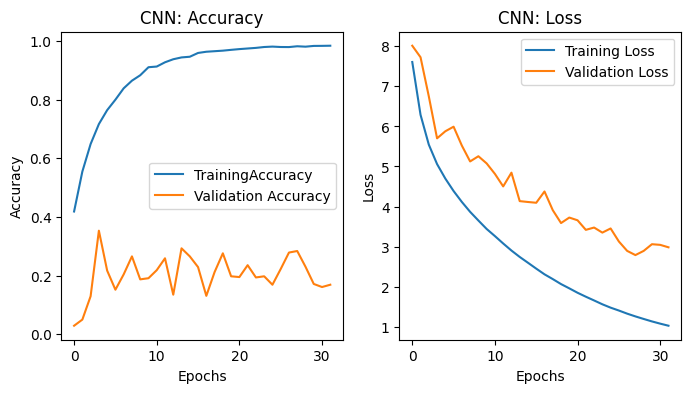

In [62]:
train_plot(MyCNN.history, 'CNN')

### Test

In [63]:
score = MyCNN.evaluate(data_test, labels_test)
print(f"{MyCNN.metrics_names[0]}: {score[0]}")
print(f"{MyCNN.metrics_names[1]}: {score[1]*100:.2f}%")

33/33 [==============================] - 1s 13ms/step - loss: 1.7449 - accuracy: 0.6533
loss: 1.744908094406128
accuracy: 65.33%


33/33 [==============================] - 1s 11ms/step


{'Accuracy': 0.6533333333333333,
 'Recall': 0.6533333333333333,
 'Precision': 0.6788084643546611,
 'F1-Score': 0.6347595214034305}

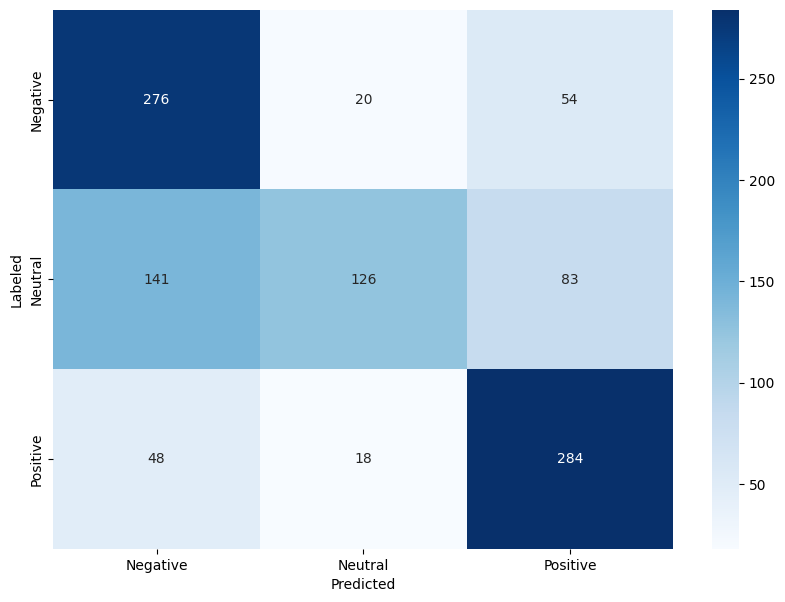

In [64]:
predictions = MyCNN.predict(data_test)
confusion_matrix_plot(predictions, labels_test)
result_test(predictions, labels_test)

## LSTM (one layer)

### Configure

In [50]:
sequence_length = data.shape[1]
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

reshape = Reshape((sequence_length, EMBEDDING_DIM))(embedding)
lstm_0 = LSTM(512)(reshape)

dropout = Dropout(drop)(lstm_0)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

# this creates a model that includes
MyLSTM = Model(inputs, output)

adam = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
MyLSTM.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
MyLSTM.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 400)          3110400   
                                                                 
 reshape_11 (Reshape)        (None, 300, 400)          0         
                                                                 
 lstm_1 (LSTM)               (None, 512)               1869824   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 4981763 (19.00 MB)
Trainable params: 4981763 

### Train

In [51]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

MyLSTM.fit(data, labels, validation_split=0.15,
          epochs=100, batch_size=512, callbacks=callbacks_list, shuffle=True)

Epoch 1/100
9/9 [==============================] - 99s 12s/step - loss: 1.0982 - accuracy: 0.4860 - val_loss: 1.6903 - val_accuracy: 0.0340
Epoch 2/100
9/9 [==============================] - 5s 576ms/step - loss: 0.8522 - accuracy: 0.6600 - val_loss: 1.6939 - val_accuracy: 0.1647
Epoch 3/100
9/9 [==============================] - 5s 590ms/step - loss: 0.7980 - accuracy: 0.6851 - val_loss: 1.8064 - val_accuracy: 0.1425
Epoch 4/100
9/9 [==============================] - 5s 593ms/step - loss: 0.7005 - accuracy: 0.7377 - val_loss: 1.5569 - val_accuracy: 0.3072
Epoch 5/100
9/9 [==============================] - 5s 586ms/step - loss: 0.5993 - accuracy: 0.7917 - val_loss: 2.2038 - val_accuracy: 0.1895
Epoch 6/100
9/9 [==============================] - 6s 666ms/step - loss: 0.5013 - accuracy: 0.8293 - val_loss: 1.8878 - val_accuracy: 0.3150
Epoch 7/100
9/9 [==============================] - 5s 611ms/step - loss: 0.4580 - accuracy: 0.8482 - val_loss: 1.5034 - val_accuracy: 0.4222
Epoch 8/100
9/

### Plot

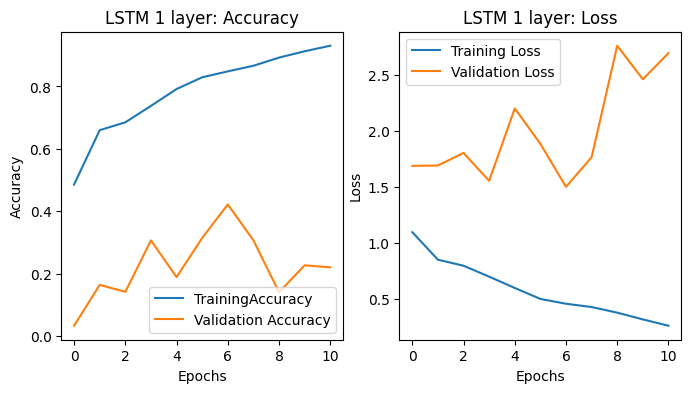

In [52]:
train_plot(MyLSTM.history, 'LSTM 1 layer')

### Test

In [54]:
score = MyLSTM.evaluate(data_test, labels_test)
print(f"{MyLSTM.metrics_names[0]}: {score[0]}")
print(f"{MyLSTM.metrics_names[1]}: {score[1]*100:.2f}%")

33/33 [==============================] - 1s 22ms/step - loss: 1.0714 - accuracy: 0.6533
loss: 1.0714476108551025
accuracy: 65.33%


33/33 [==============================] - 1s 21ms/step


{'Accuracy': 0.6533333333333333,
 'Recall': 0.6533333333333334,
 'Precision': 0.6637718412999312,
 'F1-Score': 0.6396698405813898}

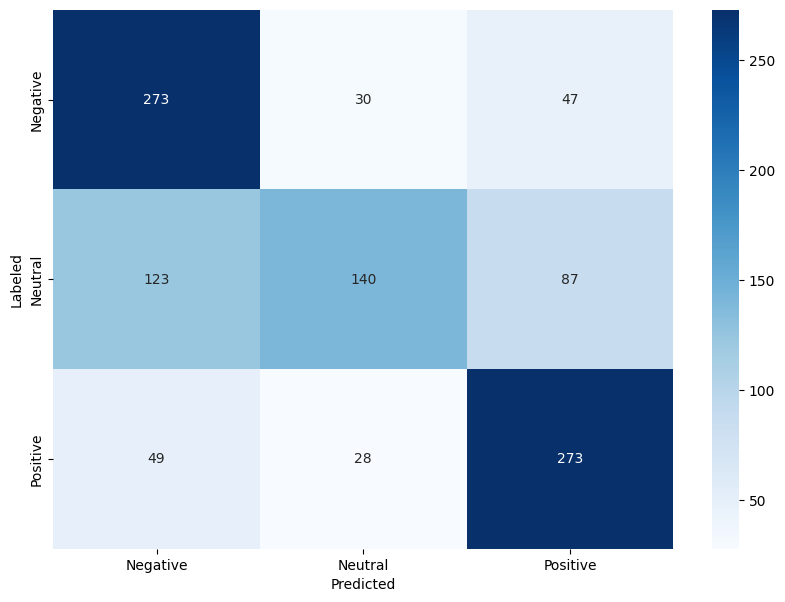

In [57]:
predictions = MyLSTM.predict(data_test)
confusion_matrix_plot(predictions, labels_test)
result_test(predictions, labels_test)

## LSTM (3 layers)

### Configure

In [82]:
sequence_length = data.shape[1]
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

reshape = Reshape((sequence_length, EMBEDDING_DIM))(embedding)
lstm_2 = LSTM(1024, return_sequences=True)(reshape)
lstm_1 = LSTM(512, return_sequences=True)(lstm_2)
lstm_0 = LSTM(256)(lstm_1)

dropout = Dropout(drop)(lstm_0)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

# this creates a model that includes
MyLSTM3L = Model(inputs, output)

adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
MyLSTM3L.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
MyLSTM3L.summary()


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 400)          3110400   
                                                                 
 reshape_31 (Reshape)        (None, 300, 400)          0         
                                                                 
 lstm_6 (LSTM)               (None, 300, 1024)         5836800   
                                                                 
 lstm_7 (LSTM)               (None, 300, 512)          3147776   
                                                                 
 lstm_8 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0  

### Train

In [84]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

MyLSTM3L.fit(data, labels, validation_split=0.15,
          epochs=100, batch_size=512, callbacks=callbacks_list, shuffle=True)

Epoch 1/100
9/9 [==============================] - 26s 3s/step - loss: 0.7652 - accuracy: 0.7087 - val_loss: 1.5398 - val_accuracy: 0.2536
Epoch 2/100
9/9 [==============================] - 26s 3s/step - loss: 0.6432 - accuracy: 0.7716 - val_loss: 2.0127 - val_accuracy: 0.1830
Epoch 3/100
9/9 [==============================] - 26s 3s/step - loss: 0.5765 - accuracy: 0.8101 - val_loss: 1.8846 - val_accuracy: 0.2523
Epoch 4/100
9/9 [==============================] - 28s 3s/step - loss: 0.5182 - accuracy: 0.8348 - val_loss: 2.2755 - val_accuracy: 0.1843
Epoch 5/100
9/9 [==============================] - 27s 3s/step - loss: 0.4739 - accuracy: 0.8544 - val_loss: 2.6398 - val_accuracy: 0.1346
Epoch 5: early stopping


### Plot

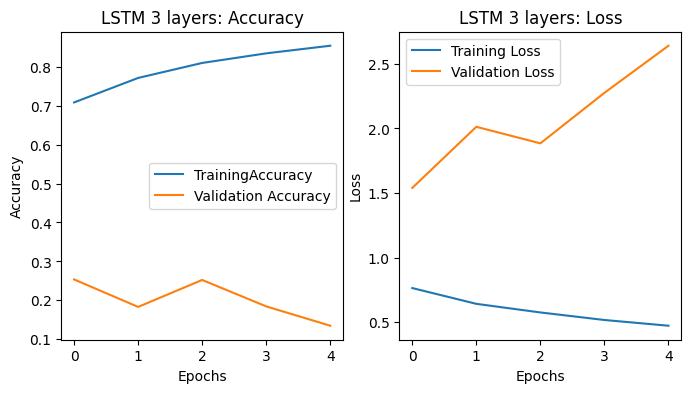

In [85]:
train_plot(MyLSTM3L.history, 'LSTM 3 layers')

### Test

In [86]:
score = MyLSTM3L.evaluate(data_test, labels_test)
print(f"{MyLSTM3L.metrics_names[0]}: {score[0]}")
print(f"{MyLSTM3L.metrics_names[1]}: {score[1]*100:.2f}%")

33/33 [==============================] - 3s 89ms/step - loss: 1.1439 - accuracy: 0.6133
loss: 1.1438947916030884
accuracy: 61.33%


33/33 [==============================] - 4s 84ms/step


{'Accuracy': 0.6133333333333333,
 'Recall': 0.6133333333333334,
 'Precision': 0.6619951146000108,
 'F1-Score': 0.5944657081811758}

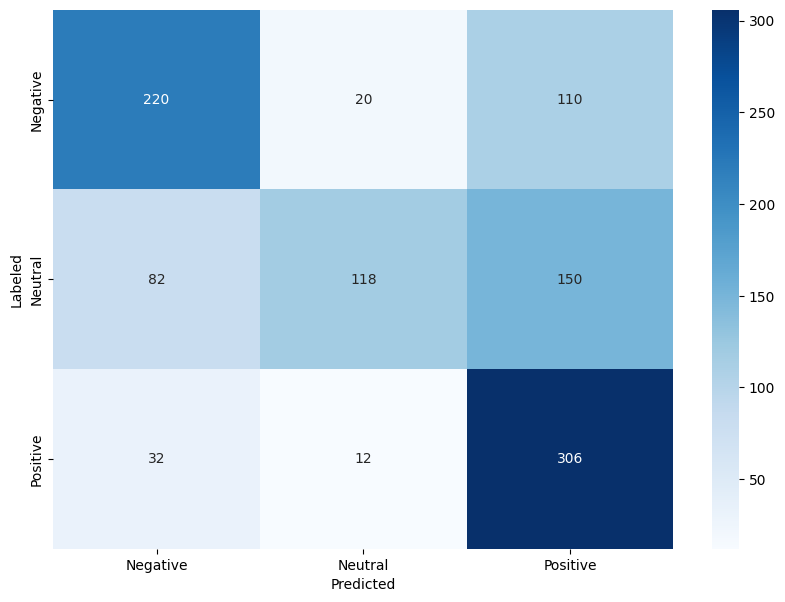

In [87]:
predictions = MyLSTM3L.predict(data_test)
confusion_matrix_plot(predictions, labels_test)
result_test(predictions, labels_test)

# Modified models

## Larger CNN

### Configure

In [65]:
sequence_length = data.shape[1]
filter_sizes = [6,10,14]
num_filters = 200
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
print(conv_1)
maxpool_0 = MaxPooling1D(sequence_length - filter_sizes[0] + 1, strides=1)(conv_0)
maxpool_1 = MaxPooling1D(sequence_length - filter_sizes[1] + 1, strides=1)(conv_1)
maxpool_2 = MaxPooling1D(sequence_length - filter_sizes[2] + 1, strides=1)(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)


# this creates a model that includes
ModCNN = Model(inputs, output)

adam = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
ModCNN.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
ModCNN.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 291, 200), dtype=tf.float32, name=None), name='conv1d_21/Relu:0', description="created by layer 'conv1d_21'")
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 300)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 300, 400)             3110400   ['input_10[0][0]']            
                                                                                                  
 conv1d_20 (Conv1D)          (None, 295, 200)             480200    ['embedding[9][0]']           
                                                                                                  
 conv1d_21 (Conv1D)          (None,

### Train

In [66]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

ModCNN.fit(data, labels, validation_split=0.15,
          epochs=100, batch_size=512, callbacks=callbacks_list, shuffle=True)

Epoch 1/100
9/9 [==============================] - 13s 1s/step - loss: 12.5087 - accuracy: 0.3804 - val_loss: 11.7466 - val_accuracy: 0.0144
Epoch 2/100
9/9 [==============================] - 5s 568ms/step - loss: 9.5836 - accuracy: 0.5834 - val_loss: 8.9887 - val_accuracy: 0.4248
Epoch 3/100
9/9 [==============================] - 5s 595ms/step - loss: 8.3875 - accuracy: 0.7089 - val_loss: 8.9186 - val_accuracy: 0.3412
Epoch 4/100
9/9 [==============================] - 5s 574ms/step - loss: 7.6058 - accuracy: 0.8009 - val_loss: 9.0166 - val_accuracy: 0.2471
Epoch 5/100
9/9 [==============================] - 6s 623ms/step - loss: 7.0893 - accuracy: 0.8528 - val_loss: 8.8339 - val_accuracy: 0.2366
Epoch 6/100
9/9 [==============================] - 5s 586ms/step - loss: 6.6270 - accuracy: 0.8964 - val_loss: 8.4822 - val_accuracy: 0.2222
Epoch 7/100
9/9 [==============================] - 5s 581ms/step - loss: 6.2101 - accuracy: 0.9250 - val_loss: 8.2010 - val_accuracy: 0.2078
Epoch 8/100
9

KeyboardInterrupt: ignored

### Plot

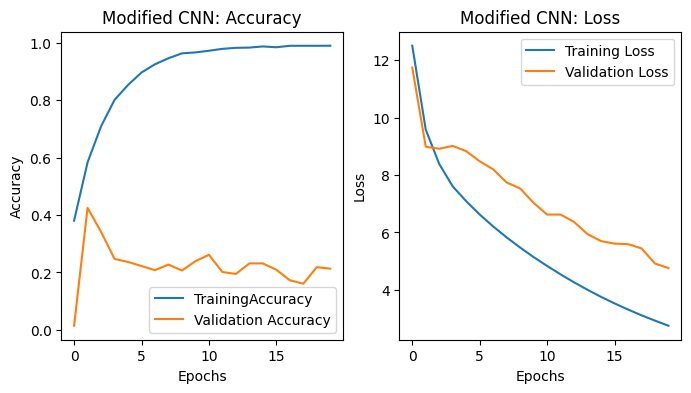

In [67]:
train_plot(ModCNN.history, 'Modified CNN')

### Test

In [68]:
score = ModCNN.evaluate(data_test, labels_test)
print(f"{ModCNN.metrics_names[0]}: {score[0]}")
print(f"{ModCNN.metrics_names[1]}: {score[1]*100:.2f}%")

33/33 [==============================] - 1s 17ms/step - loss: 3.3278 - accuracy: 0.6629
loss: 3.3278162479400635
accuracy: 66.29%


33/33 [==============================] - 0s 11ms/step


{'Accuracy': 0.6628571428571428,
 'Recall': 0.6628571428571428,
 'Precision': 0.6832185124465996,
 'F1-Score': 0.649380291524832}

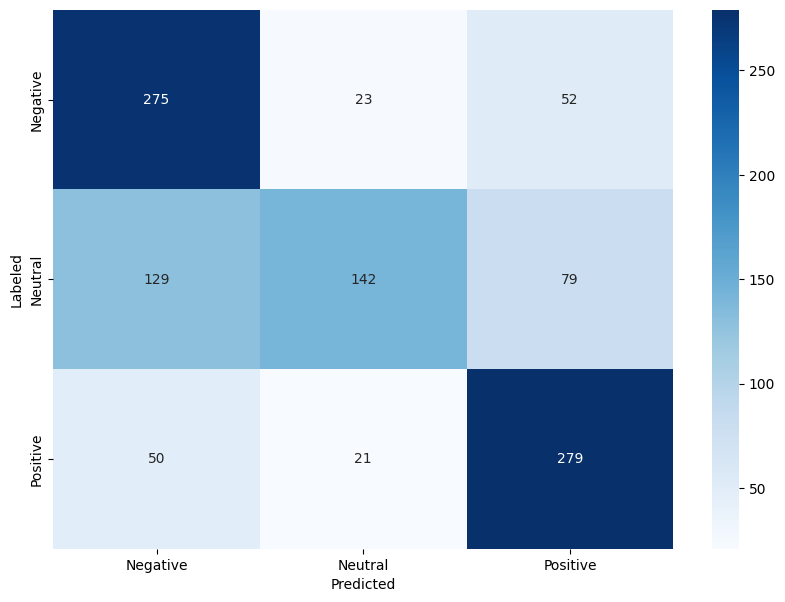

In [69]:
predictions = ModCNN.predict(data_test)
confusion_matrix_plot(predictions, labels_test)
result_test(predictions, labels_test)

## BiLSTM

### Configure

In [95]:
sequence_length = data.shape[1]
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)

lstm_0 = Bidirectional(LSTM(1024,))(reshape)

dropout = Dropout(drop)(lstm_0)
output = Dense(units=3, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(dropout)
MyBiLSTM = Model(inputs, output)

adam = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, weight_decay=0.0)
MyBiLSTM.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
MyBiLSTM.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 400)          3110400   
                                                                 
 reshape_32 (Reshape)        (None, 300, 400)          0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 2048)              11673600  
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 2048)              0         
                                                                 
 dense_15 (Dense)            (None, 3)                 6147      
                                                          

### Train

In [96]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

MyBiLSTM.fit(data, labels, validation_split=0.15,
          epochs=100, batch_size=256, callbacks=callbacks_list, shuffle=True)

Epoch 1/100
17/17 [==============================] - 34s 2s/step - loss: 1.0533 - accuracy: 0.5430 - val_loss: 1.1311 - val_accuracy: 0.5229
Epoch 2/100
17/17 [==============================] - 32s 2s/step - loss: 0.6715 - accuracy: 0.7493 - val_loss: 2.2949 - val_accuracy: 0.0824
Epoch 3/100
17/17 [==============================] - 31s 2s/step - loss: 0.4811 - accuracy: 0.8295 - val_loss: 1.6136 - val_accuracy: 0.3608
Epoch 4/100
17/17 [==============================] - 33s 2s/step - loss: 0.3544 - accuracy: 0.8939 - val_loss: 1.8823 - val_accuracy: 0.3072
Epoch 5/100
17/17 [==============================] - 33s 2s/step - loss: 0.2792 - accuracy: 0.9239 - val_loss: 1.9211 - val_accuracy: 0.3595
Epoch 5: early stopping


### Plot

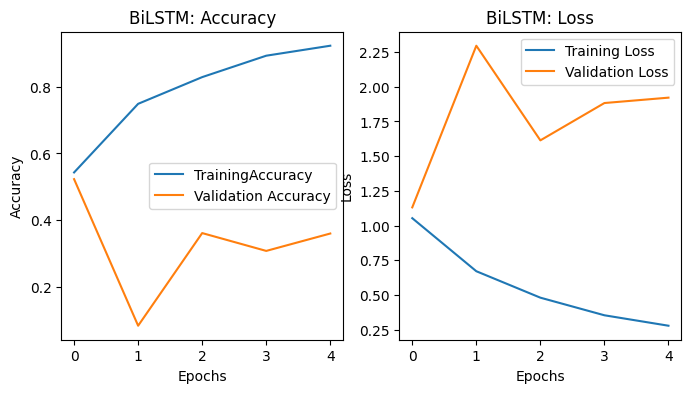

In [99]:
train_plot(MyBiLSTM.history, 'BiLSTM')

### Test

In [100]:
score = MyBiLSTM.evaluate(data_test, labels_test)
print(f"{MyBiLSTM.metrics_names[0]}: {score[0]}")
print(f"{MyBiLSTM.metrics_names[1]}: {score[1]*100:.2f}%")

33/33 [==============================] - 3s 100ms/step - loss: 1.0347 - accuracy: 0.6610
loss: 1.0346523523330688
accuracy: 66.10%


33/33 [==============================] - 4s 94ms/step


{'Accuracy': 0.660952380952381,
 'Recall': 0.6609523809523808,
 'Precision': 0.6580988964927718,
 'F1-Score': 0.6573950324785632}

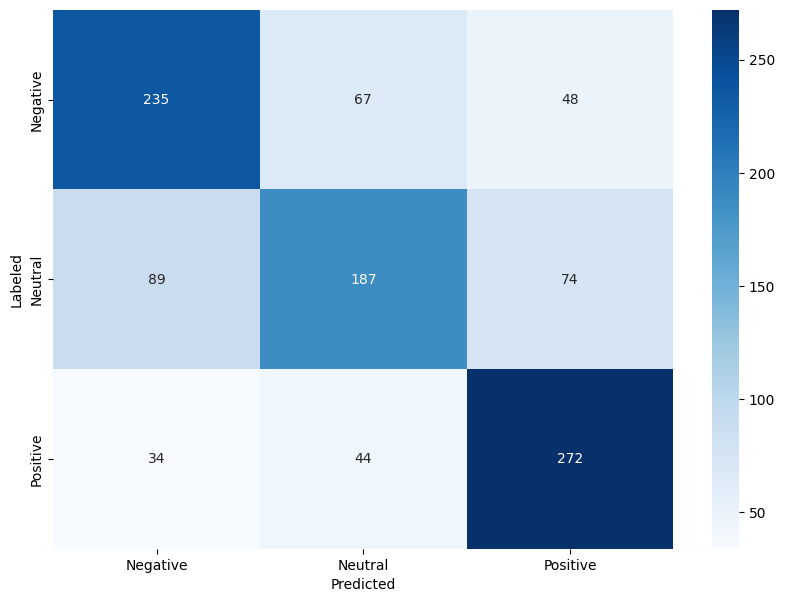

In [101]:
predictions = MyBiLSTM.predict(data_test)
confusion_matrix_plot(predictions, labels_test)
result_test(predictions, labels_test)

## Larger CNN + BiLSTM

### Configure

In [77]:
sequence_length = data.shape[1]
filter_sizes = [6,10,14]
num_filters = 200
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

reshape = Reshape((sequence_length, EMBEDDING_DIM))(embedding)

conv_0 = Conv1D(num_filters, (filter_sizes[0],), padding="same", activation='relu', kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv1D(num_filters, (filter_sizes[1],), padding="same", activation='relu', kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv1D(num_filters, (filter_sizes[2],), padding="same", activation='relu', kernel_regularizer=regularizers.l2(0.01))(reshape)

conv_0 = MaxPool1D(300)(conv_0)
conv_1 = MaxPool1D(300)(conv_1)
conv_2 = MaxPool1D(300)(conv_2)
# Reshape output to match RNN dimension
conv_0 = Reshape((-1, num_filters))(conv_0)
conv_1 = Reshape((-1, num_filters))(conv_1)
conv_2 = Reshape((-1, num_filters))(conv_2)

concat = concatenate([conv_0, conv_1, conv_2])
# concat = Flatten()(concat)

# Replace three LSTM layers with a single Bidirectional LSTM layer
bilstm_layer = Bidirectional(LSTM(512))(concat)

dropout = Dropout(drop)(bilstm_layer)
output = Dense(units=3, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(dropout)

# This creates a model that includes
ModCNNBiLSTM = Model(inputs, output)

adam = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
ModCNNBiLSTM.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
ModCNNBiLSTM.summary()


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 300)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 300, 400)             3110400   ['input_14[0][0]']            
                                                                                                  
 reshape_27 (Reshape)        (None, 300, 400)             0         ['embedding[13][0]']          
                                                                                                  
 conv1d_29 (Conv1D)          (None, 300, 200)             480200    ['reshape_27[0][0]']          
                                                                                           

### Train

In [78]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

ModCNNBiLSTM.fit(data, labels, validation_split=0.1,
          epochs=100, batch_size=256, callbacks=callbacks_list, shuffle=True)

Epoch 1/100
18/18 [==============================] - 21s 708ms/step - loss: 7.7055 - accuracy: 0.4026 - val_loss: 6.2356 - val_accuracy: 0.0000e+00
Epoch 2/100
18/18 [==============================] - 5s 298ms/step - loss: 4.4444 - accuracy: 0.5784 - val_loss: 3.7566 - val_accuracy: 0.2588
Epoch 3/100
18/18 [==============================] - 6s 330ms/step - loss: 2.5171 - accuracy: 0.7390 - val_loss: 2.2838 - val_accuracy: 0.5667
Epoch 4/100
18/18 [==============================] - 6s 351ms/step - loss: 1.5017 - accuracy: 0.8828 - val_loss: 2.2003 - val_accuracy: 0.4196
Epoch 5/100
18/18 [==============================] - 6s 317ms/step - loss: 0.9290 - accuracy: 0.9756 - val_loss: 2.3517 - val_accuracy: 0.3608
Epoch 6/100
18/18 [==============================] - 7s 386ms/step - loss: 0.6217 - accuracy: 0.9972 - val_loss: 2.1584 - val_accuracy: 0.4333
Epoch 7/100
18/18 [==============================] - 6s 320ms/step - loss: 0.4330 - accuracy: 0.9993 - val_loss: 1.6749 - val_accuracy: 0

KeyboardInterrupt: ignored

### Plot

In [ ]:
train_plot(MyCNNBiLSTM.history, 'Larger CNN + BiLSTM')

### Test

In [80]:
score = MyCNNBiLSTM.evaluate(data_test, labels_test)
print(f"{MyCNNBiLSTM.metrics_names[0]}: {score[0]}")
print(f"{MyCNNBiLSTM.metrics_names[1]}: {score[1]*100:.2f}%")

33/33 [==============================] - 1s 26ms/step - loss: 1.1747 - accuracy: 0.7000
loss: 1.1746915578842163
accuracy: 70.00%


33/33 [==============================] - 3s 15ms/step


{'Accuracy': 0.7,
 'Recall': 0.7000000000000001,
 'Precision': 0.7051125920691138,
 'F1-Score': 0.6949168928782092}

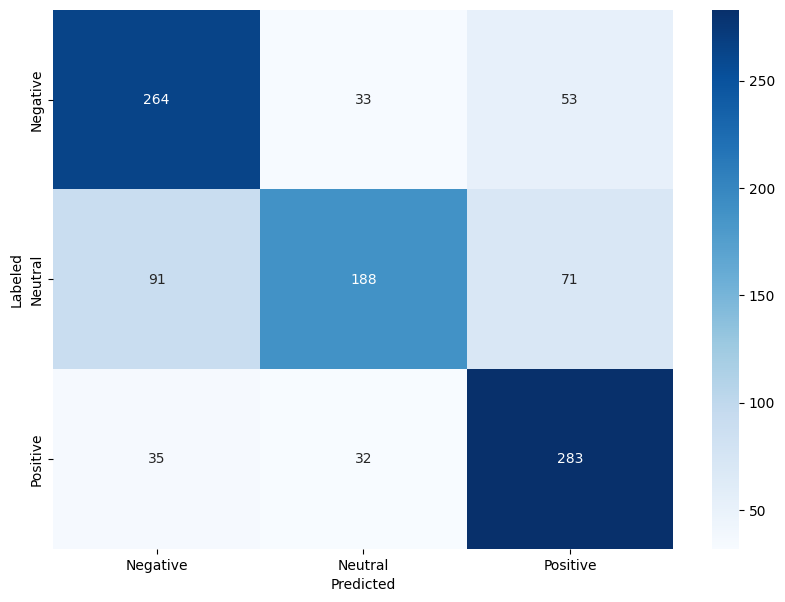

In [81]:
predictions = MyCNNBiLSTM.predict(data_test)
confusion_matrix_plot(predictions, labels_test)
result_test(predictions, labels_test)